<a href="https://colab.research.google.com/github/xpandalord/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!
# Imports
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

In [0]:
# In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate
# a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000.
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
  """
  A function to generate the posterior probability given the prior probability, false positive rate, and true positive rate.
  """
  prob_not_drunk_prior = 1 - prob_drunk_prior
  numerator = true_positive_rate * prob_drunk_prior
  marginal = (true_positive_rate * prob_drunk_prior) + (false_positive_rate * prob_not_drunk_prior)
  posterior_probability = numerator / marginal
  return posterior_probability

In [3]:
# What is the probability that a person is drunk after one positive breathalyzer test?
prob_drunk_given_positive(0.001, 0.08, 1)

0.012357884330202669

In [0]:
def prob_drunk_given_positive_multiple_tests(prob_drunk_prior, false_positive_rate, true_positive_rate, number_of_tests):
  """
  A function to generate the posterior probability given the prior probability, false positive rate, true positive rate, and amount of tests.
  """
  posterior_probability = prob_drunk_prior
  for test in range(0, number_of_tests):
    prob_drunk_prior = posterior_probability
    prob_not_drunk_prior = 1 - prob_drunk_prior
    numerator = true_positive_rate * prob_drunk_prior
    marginal = (true_positive_rate * prob_drunk_prior) + (false_positive_rate * prob_not_drunk_prior)
    posterior_probability = numerator / marginal
  return posterior_probability

In [7]:
# What is the probability that a person is drunk after two positive breathalyzer tests?
prob_drunk_given_positive_multiple_tests(0.001, 0.08, 1, 2)

0.13525210993291495

In [31]:
# How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?
print(prob_drunk_given_positive_multiple_tests(0.001, 0.08, 1, 3))
print(prob_drunk_given_positive_multiple_tests(0.001, 0.08, 1, 4))

0.6615996951348605
0.9606895076105054


In [0]:
# Reading in the dataframe
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")

In [46]:
# Mean age
df['age'].mean()

38.58164675532078

In [50]:
# Frequentist Approach
# Calculate a 95% confidence interval on either side of the mean.
conf_freq = stats.t.interval(0.95,                        # alpha (i.e., confidence level)
                             df.shape[0],                 # length of sample
                             loc = df['age'].mean(),      # sample mean
                             scale = stats.sem(df['age']) # std error of the mean
                             )
conf_freq

(38.433482476875845, 38.72981103376572)

In [52]:
# Bayesian Approach
conf_bayes = stats.bayes_mvs(df['age'], alpha = 0.95)[0][1] # alpha is the confidence level for this equation
conf_bayes

(38.433490259580736, 38.72980325106083)

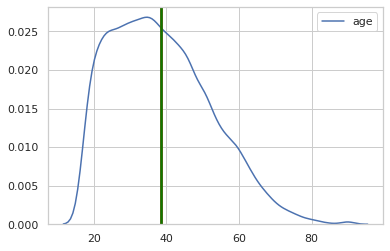

In [74]:
# plot on a graph with kernel density estimate
sns.kdeplot(df['age'])
plt.axvline(x = conf_freq[0], color = 'red')
plt.axvline(x = conf_freq[1], color = 'red')
plt.axvline(x = conf_bayes[0], color = 'green')
plt.axvline(x = conf_bayes[1], color = 'green')

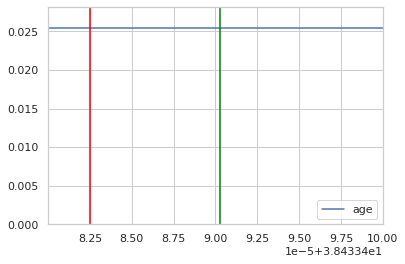

In [71]:
# Mean - margin of error
sns.kdeplot(df['age'])
plt.xlim(38.43348, 38.4335)
plt.axvline(x = conf_freq[0], color = 'red')
plt.axvline(x = conf_freq[1], color = 'red')
plt.axvline(x = conf_bayes[0], color = 'green')
plt.axvline(x = conf_bayes[1], color = 'green')

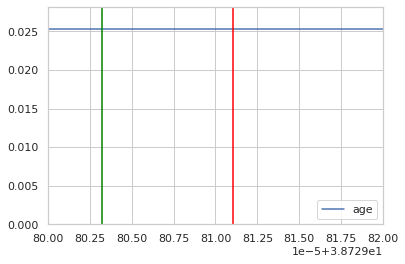

In [73]:
# Mean + margin of error
sns.kdeplot(df['age'])
plt.xlim(38.7298, 38.72982)
plt.axvline(x = conf_freq[0], color = 'red')
plt.axvline(x = conf_freq[1], color = 'red')
plt.axvline(x = conf_bayes[0], color = 'green')
plt.axvline(x = conf_bayes[1], color = 'green')

The difference between Bayesian and Frequentist statistics is the beginning conclusions. Bayesian statistics include a prior probability preventing their post probability from being wildly far from the true answer. However, it depends on how good of an estimate the prior probability is. Frequentist statistics can start out having concluded a very far off probability but by sampling many times, they will eventually obtain the true result. Thus, you should use Bayesian statistics when possible because in either case, sampling will bring you closer to the true probability so Bayesian statistics will at least bring you a step in the right direction from the start.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!